In [116]:
# === leitura_serial + conversão WFDB com anotações ===
import serial
import numpy as np
import wfdb
from datetime import datetime
from scipy.signal import butter, find_peaks, sosfiltfilt

# === CONFIGURAÇÕES SERIAL E ARQUIVO ===
porta_serial = 'COM7'
baudrate = 115200
tempo_coleta_seg = 10
taxa_amostragem = 977
arquivo_txt = 'ecg_bruto.txt'
arquivo_wfdb = 'meu_ecg_filtrado'

# === CONFIGURAÇÕES DO ADC E SINAL ===
adc_bits = 12
adc_max = 2**adc_bits - 1  # 4095
v_ref = 3.3  # volts
ganho_adc = 1  # 1 unidade = 5 µV → evita estouro com fmt='16'

# === FILTRO PASSA-FAIXA ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=2):
    nyq = 0.5 * fs
    sos = butter(ordem, [lowcut / nyq, highcut / nyq], btype='band', output='sos')
    return sosfiltfilt(sos, signal)

# === LEITURA SERIAL ===
num_amostras = tempo_coleta_seg * taxa_amostragem
valores = []

print(f"⏳ Conectando na serial {porta_serial} a {baudrate} baud...")
with serial.Serial(porta_serial, baudrate, timeout=1) as ser:
    print(f"📡 Coletando {tempo_coleta_seg} segundos de sinal ({num_amostras} amostras)...")
    while len(valores) < num_amostras:
        try:
            linha = ser.readline().decode(errors='ignore').strip()
            valor = int(linha)
            if 0 <= valor <= adc_max:
                valores.append(valor)
            if len(valores) % 1000 == 0:
                print(f"  → {len(valores)} amostras coletadas...")
        except:
            continue

print(f"🔎 Primeiras 10 amostras: {valores[:10]}")
print(f"📊 Estatísticas — min: {np.min(valores)}, max: {np.max(valores)}, média: {np.mean(valores)}")


# === SALVAMENTO COMO TXT ===
print(f"💾 Salvando {len(valores)} amostras em {arquivo_txt}...")
with open(arquivo_txt, 'w') as f:
    for v in valores:
        f.write(f"{v}\n")

⏳ Conectando na serial COM7 a 115200 baud...
📡 Coletando 10 segundos de sinal (9770 amostras)...
  → 1000 amostras coletadas...
  → 2000 amostras coletadas...
  → 3000 amostras coletadas...
  → 4000 amostras coletadas...
  → 5000 amostras coletadas...
  → 6000 amostras coletadas...
  → 7000 amostras coletadas...
  → 8000 amostras coletadas...
  → 9000 amostras coletadas...
🔎 Primeiras 10 amostras: [4094, 4085, 4081, 4095, 4095, 4095, 4063, 4085, 3991, 4090]
📊 Estatísticas — min: 3878, max: 4095, média: 4081.5290685772775
💾 Salvando 9770 amostras em ecg_bruto.txt...


In [109]:
# === PROCESSAMENTO PARA WFDB ===
from scipy.signal import iirnotch
from scipy.signal import find_peaks

sinal_adc = np.array(valores)
sinal_mv = (sinal_adc / adc_max) * v_ref * 1000  # em mV
sinal_centralizado = sinal_mv - np.mean(sinal_mv)
sinal_centralizado = sinal_centralizado[100:-100]  # remove artefatos de borda



def filtro_notch(signal, fs, f_notch=60.0, Q=30):
    b, a = iirnotch(f_notch, Q, fs)
    return sosfiltfilt([[b[0], b[1], b[2], a[0], a[1], 0.0]], signal)


sinal_sem_60hz = filtro_notch(sinal_centralizado, taxa_amostragem)
sinal_filtrado = filtro_passa_faixa(sinal_sem_60hz, taxa_amostragem,lowcut=0.05, highcut=100.0)


# Proteção extra: evita picos fora de faixa do fmt=16
sinal_limpo ##= np.clip(sinal_filtrado, -5.0, 5.0)  # mV

sinal_final = sinal_limpo.reshape(-1, 1)  # formato (n, 1)

# === SALVANDO COMO WFDB (.dat + .hea) ===
wfdb.wrsamp(
    record_name=arquivo_wfdb,
    fs=taxa_amostragem,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=sinal_final,
    fmt=['16'],
    adc_gain=[ganho_adc],
    baseline=[0],
    comments=[f"Capturado, filtrado e ajustado em {datetime.now()}"]
)

# Reabre e ajusta os metadados (adcres)
record = wfdb.rdrecord(arquivo_wfdb)
record.adcres = [12]
record.wrheader()

print(f"✅ Arquivo WFDB salvo como: {arquivo_wfdb}.dat + {arquivo_wfdb}.hea")

# === GERAÇÃO DE ANOTAÇÕES (batimentos simulados) ===
from scipy.signal import find_peaks

picos, _ = find_peaks(sinal_filtrado, distance=taxa_amostragem * 0.3, height=0.1, prominence=0.05)

if len(picos) == 0:
    print("⚠️ Nenhum batimento detectado. .atr não será gerado.")
else:
    symbols = ['N'] * len(picos)
    wfdb.wrann(
        record_name=arquivo_wfdb,
        extension='atr',
        sample=picos,
        symbol=symbols,
        fs=taxa_amostragem
    )
    print(f"📝 Anotações (.atr) geradas com {len(picos)} batimentos (símbolo 'N')")


✅ Arquivo WFDB salvo como: meu_ecg_filtrado.dat + meu_ecg_filtrado.hea
⚠️ Nenhum batimento detectado. .atr não será gerado.


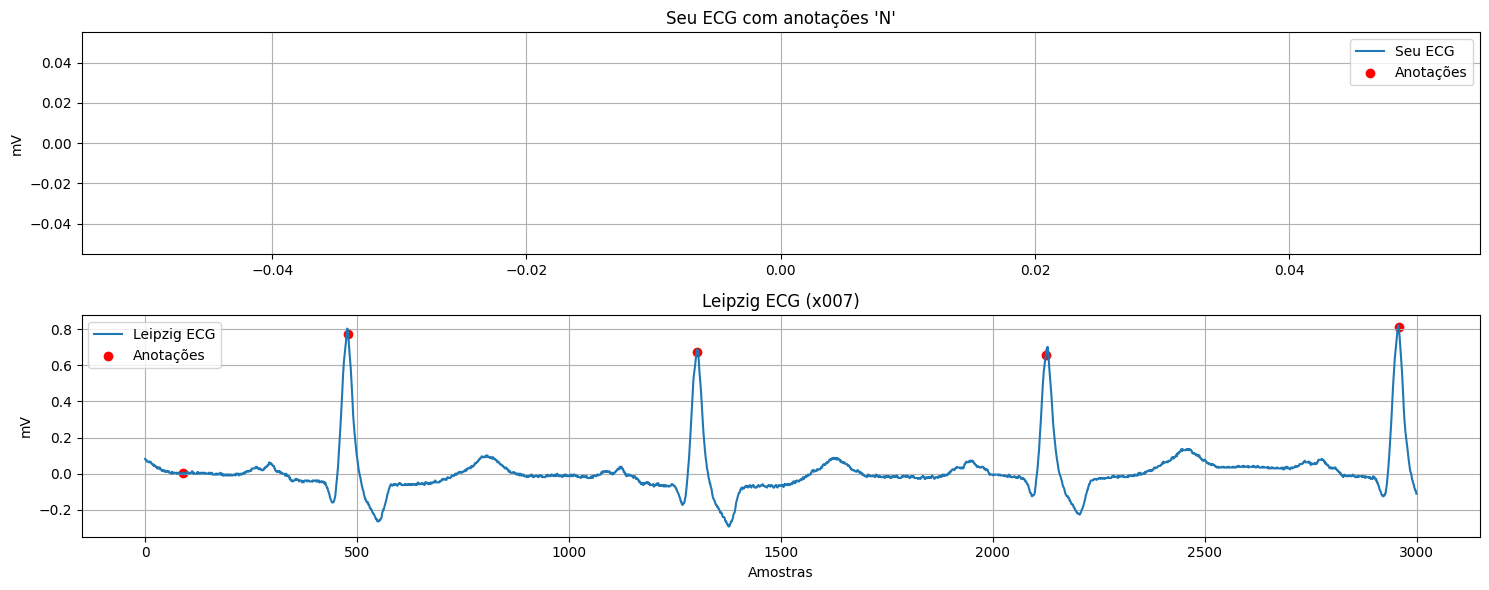

In [100]:
import wfdb
import matplotlib.pyplot as plt

# Lê seu ECG processado com anotações
user_record = wfdb.rdrecord("meu_ecg_filtrado")
user_ann = wfdb.rdann("meu_ecg_filtrado", "atr")

# Lê um registro Leipzig (exemplo: x007)
leipzig_record = wfdb.rdrecord(r'C:\Users\Stella\Desktop\TCC\db\x102')
leipzig_ann = wfdb.rdann(r'C:\Users\Stella\Desktop\TCC\db\x102', 'atr')

# Quantas amostras mostrar (ex: ~3 segundos)
samples_to_plot = 3000

plt.figure(figsize=(15, 6))

# ECG do usuário
plt.subplot(2, 1, 1)
plt.plot(user_record.p_signal[:samples_to_plot, 0], label='Seu ECG')
plt.scatter(
    [s for s in user_ann.sample if s < samples_to_plot],
    user_record.p_signal[user_ann.sample[user_ann.sample < samples_to_plot], 0],
    color='red', label='Anotações'
)
plt.title("Seu ECG com anotações 'N'")
plt.ylabel("mV")
plt.legend()
plt.grid()

# ECG do Leipzig
plt.subplot(2, 1, 2)
plt.plot(leipzig_record.p_signal[:samples_to_plot, 0], label='Leipzig ECG')
plt.scatter(
    [s for s in leipzig_ann.sample if s < samples_to_plot],
    leipzig_record.p_signal[leipzig_ann.sample[leipzig_ann.sample < samples_to_plot], 0],
    color='red', label='Anotações'
)
plt.title("Leipzig ECG (x007)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


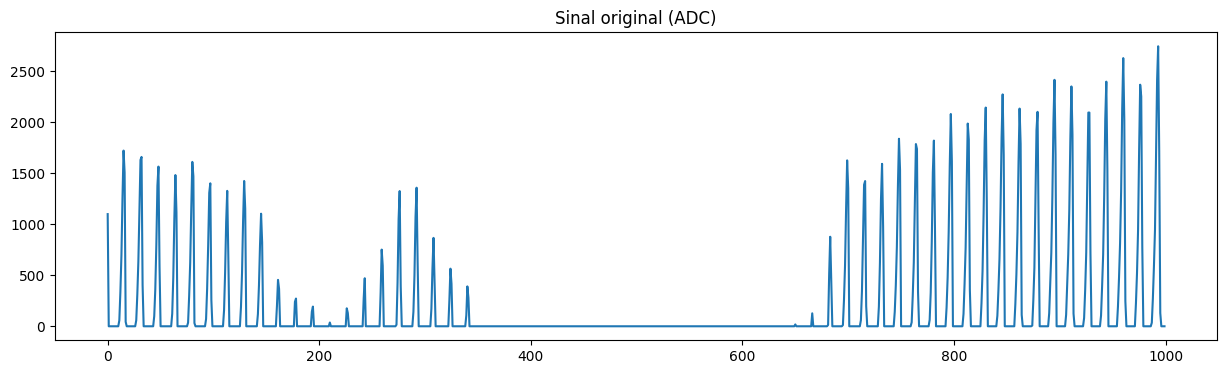

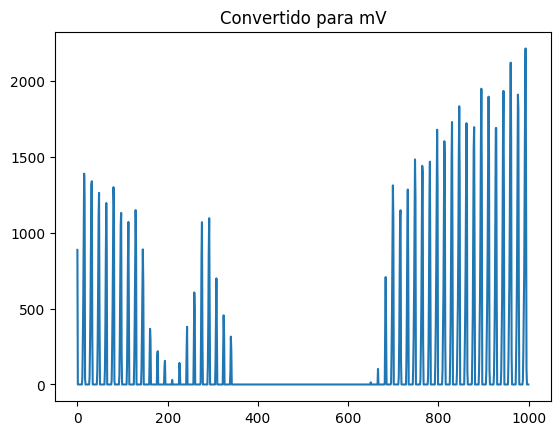

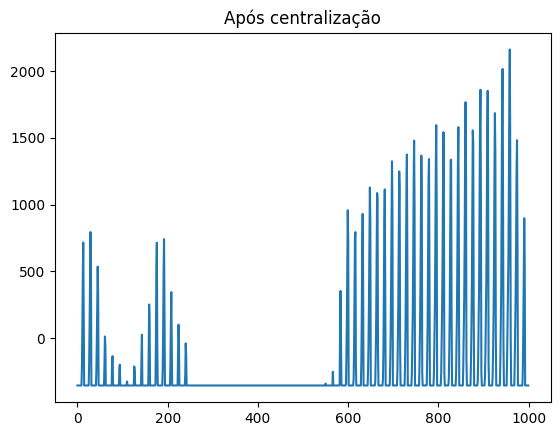

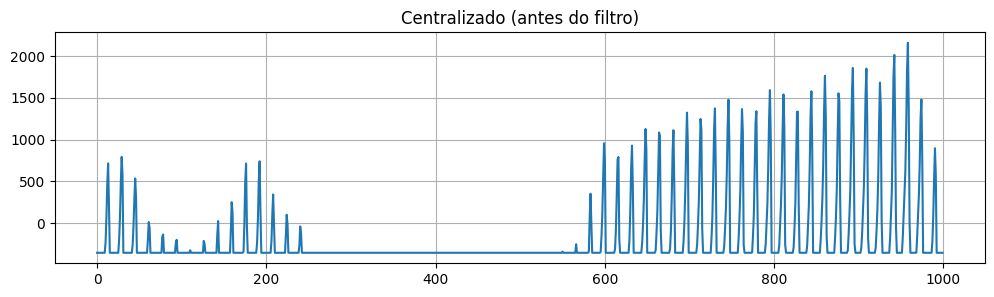

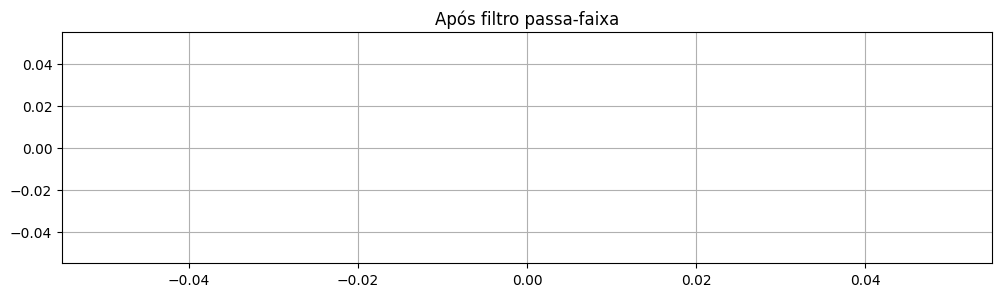

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(sinal_adc[:1000])
plt.title("Sinal original (ADC)")
plt.show()

plt.plot(sinal_mv[:1000])
plt.title("Convertido para mV")
plt.show()

plt.plot(sinal_centralizado[:1000])
plt.title("Após centralização")
plt.show()


plt.figure(figsize=(12, 3))
plt.plot(sinal_centralizado[:1000])
plt.title("Centralizado (antes do filtro)")
plt.grid()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(sinal_filtrado[:1000])
plt.title("Após filtro passa-faixa")
plt.grid()
plt.show()


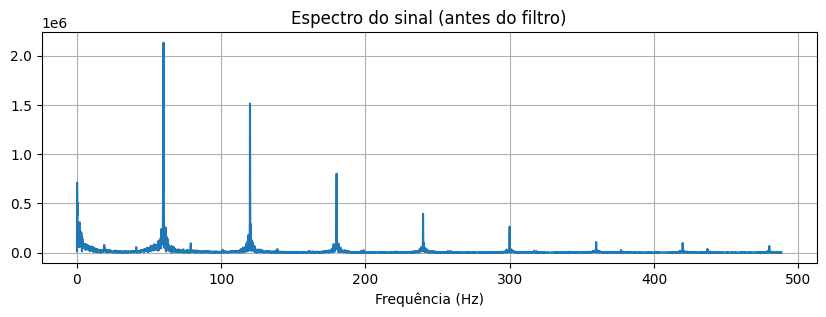

In [106]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

N = len(sinal_centralizado)
yf = fft(sinal_centralizado)
xf = fftfreq(N, 1 / taxa_amostragem)

plt.figure(figsize=(10, 3))
plt.plot(xf[:N // 2], np.abs(yf[:N // 2]))
plt.title("Espectro do sinal (antes do filtro)")
plt.xlabel("Frequência (Hz)")
plt.grid()
plt.show()

In [59]:
import numpy as np
import wfdb
from datetime import datetime
from scipy.signal import butter, filtfilt

# === CONFIGURAÇÕES ===
arquivo_entrada = 'ecg_bruto.txt'
arquivo_saida = 'meu_ecg_filtrado'
adc_bits = 12
v_ref = 3.3
fs = 977
ganho_adc = 10  # compatível com PhysioNet fmt='16'

# === FILTRO PASSA-FAIXA ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=8):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(ordem, [low, high], btype='band')
    return filtfilt(b, a, signal)



def filtro_notch(signal, fs, f_notch=60.0, Q=30):
    b, a = iirnotch(f_notch, Q, fs)
    return sosfiltfilt([[b[0], b[1], b[2], a[0], a[1], 0.0]], signal)


# === LEITURA SEGURA DO ARQUIVO ===
valores_adc = []
with open(arquivo_entrada, 'r') as f:
    for linha in f:
        try:
            valor = int(linha.strip())
            if 0 <= valor <= 4095:
                valores_adc.append(valor)
        except ValueError:
            continue

valores_adc = np.array(valores_adc)
print(f"Amostras: {len(valores_adc)}")

# === CONVERSÃO PARA mV + CENTRALIZAÇÃO ===
valores_mv = (valores_adc / (2**adc_bits - 1)) * v_ref * 1000
valores_mv -= np.mean(valores_mv)
valores_mv = np.nan_to_num(valores_mv)

print(f"Faixa (mV): min = {np.min(valores_mv):.2f}, max = {np.max(valores_mv):.2f}")



# === FILTRO NOTCH ===
sinal_sem_60hz = filtro_notch(valores_mv, fs)

# === FILTRO PASSA-FAIXA ===
valores_filtrados = filtro_passa_faixa(sinal_sem_60hz, fs)


valores_filtrados = np.nan_to_num(valores_filtrados)

# === OPCIONAL: SUAVIZAÇÃO ===
# def suavizar(signal, janela=5):
#     return np.convolve(signal, np.ones(janela)/janela, mode='same')
# valores_filtrados = suavizar(valores_filtrados, janela=3)

# === VERIFICAÇÕES FINAIS ===
print("🔍 Faixa do sinal exportado em mV:")
print(f"Min: {np.min(valores_filtrados):.2f}")
print(f"Max: {np.max(valores_filtrados):.2f}")
print("Contém NaN?", np.isnan(valores_filtrados).any())

# === CONVERSÃO PARA WFDB ===
valores_np = valores_filtrados.reshape(-1, 1)

wfdb.wrsamp(
    record_name=arquivo_saida,
    fs=fs,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=valores_np,
    fmt=['16'],
    adc_gain=[ganho_adc],
    adc_res=[12],
    baseline=[0],
    comments=[f'Convertido com filtro passa-faixa e centralização, {datetime.now()}']
)

print(f"✅ Arquivos salvos: {arquivo_saida}.hea e {arquivo_saida}.dat")


Amostras: 9770
Faixa (mV): min = 0.00, max = 0.00
🔍 Faixa do sinal exportado em mV:
Min: 0.00
Max: 0.00
Contém NaN? False


TypeError: wrsamp() got an unexpected keyword argument 'adc_res'

Frequência de amostragem: 977 Hz


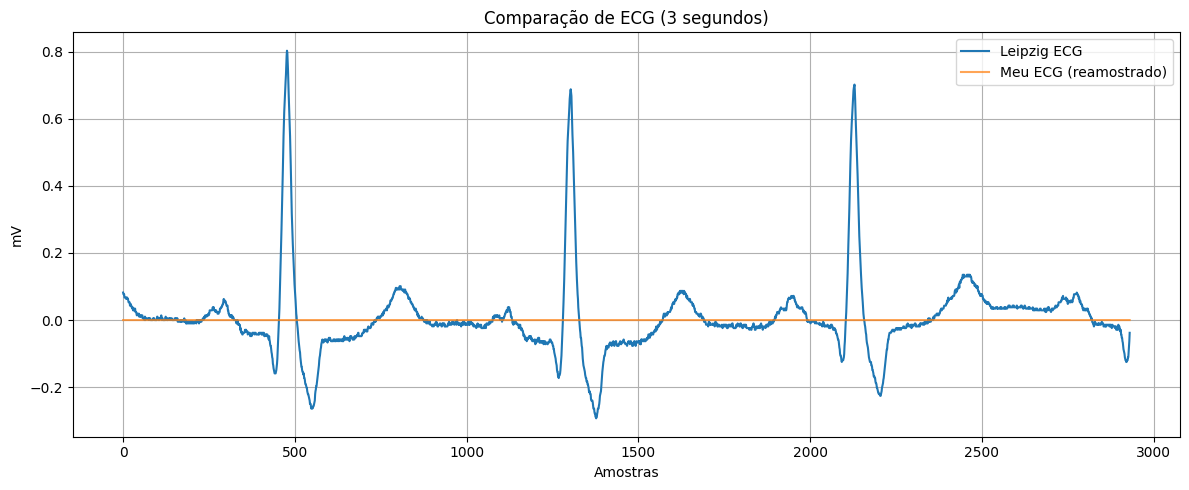

In [88]:
import wfdb


# Caminho completo sem extensão (.hea, .dat, .atr)
caminho_arquivo = r'C:\Users\Stella\Desktop\TCC\db\x102'
# Lê o registro
leipzig_record = wfdb.rdrecord(caminho_arquivo)

# Exemplo: carregar paciente x001 (criança)
leipzig_signal = leipzig_record.p_signal[:, 0]
fs_leipzig = leipzig_record.fs

print(f'Frequência de amostragem: {fs_leipzig} Hz')

meu_record = wfdb.rdrecord(r'C:\Users\Stella\Desktop\TCC\meu_ecg_filtrado')
meu_signal = -meu_record.p_signal[:, 0]
fs_meu = meu_record.fs


import matplotlib.pyplot as plt

n_amostras = fs_leipzig * 3  # 3 segundos

plt.figure(figsize=(12, 5))
plt.plot(leipzig_signal[:n_amostras], label='Leipzig ECG')
plt.plot(meu_signal[:n_amostras], label='Meu ECG (reamostrado)', alpha=0.7)
plt.legend()
plt.title("Comparação de ECG (3 segundos)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
plt.figure(figsize=(12, 5))
plt.plot(leipzig_signal[:n_amostras], label='Leipzig ECG')
plt.plot(meu_signal[:n_amostras], label='Meu ECG (filtrado + suavizado)', alpha=0.7)
plt.title("Comparação de ECG (3 segundos)")
plt.xlabel("Amostras")
plt.ylabel("mV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

35 picos encontrados.


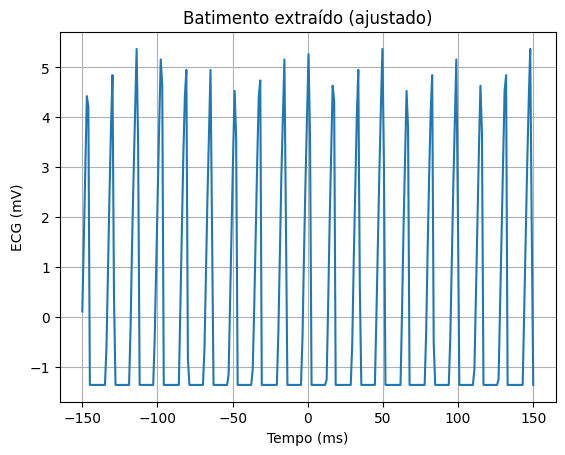

In [23]:
from scipy.signal import find_peaks

# Ajuste da altura mínima para detecção de picos
min_altura = 0.5  # Ajuste conforme necessário

# Encontre os picos
picos, _ = find_peaks(-meu_signal, height=min_altura, distance=200)

if len(picos) == 0:
    print("Nenhum pico encontrado.")
else:
    print(f"{len(picos)} picos encontrados.")
    idx = picos[len(picos)//2]  # Seleciona um pico do meio
    janela = 300  # Janela de 300 amostras (~300ms para cada lado)
    batimento = -meu_signal[idx - janela//2 : idx + janela//2]  # Extração do batimento

    # Plotando o batimento extraído
    tempo = np.linspace(-150, 150, janela)
    plt.plot(tempo, batimento)
    plt.title("Batimento extraído (ajustado)")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("ECG (mV)")
    plt.grid(True)
    plt.show()
